In [1]:
%load_ext autoreload
%autoreload 2

# Imports
## Common libs
import pandas as pd
import numpy as np
import pickle
from itertools import cycle, chain
from copy import deepcopy
from datetime import datetime
from collections import OrderedDict

## Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.pyplot import rc

## Graphs
from networkx.drawing import nx_agraph
import networkx as nx
from graphviz import Source
import pygraphviz

## GPs
from GPy.kern import RBF
from GPy.models.gp_regression import GPRegression

## DCBO Utils
import sys
sys.path.append("../DCBO")
from src.utils.utilities import powerset
from src.utils.sem_utils.sem_estimate import build_sem_hat
from src.utils.sequential_intervention_functions import get_interventional_grids
from src.experimental.experiments import optimal_sequence_of_interventions, run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate
from src.utils.plotting import plot_expected_opt_curve_paper

## Optimisation Algos
from src.methods.cbo import CBO
from src.methods.dcbo import DCBO
from src.methods.bo import BO

## YT
import random
from gym import spaces
from numpy import repeat
from stable_baselines3.common.env_checker import check_env

sys.path.append("../YAWNING-TITAN_fork")
from yawning_titan.integrations.dcbo.dcbo_agent import DCBOAgent
from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.helpers import network_creator

# Problem Setup
* We want to use YAWNING TITAN to simulate data for a range of probabilities for $P$ and $I$
* We want to generate data for 50 timesteps in each environment
* We then want to use BO, CBO and DCBO to take that data and determine the optimal value for $P$ and $I$ in the final 3 timesteps

### First, we need to define our DAG
* This will be our causal model of how compromise spreads in our example network (Fig. 2 in the paper)
* It will also define what data we need to collect from YAWNING TITAN

In [2]:
# How many timesteps we want to visaulise:
T = 3

In [3]:
def picshat_graph(start_time: int, stop_time: int, verbose=False):
    """
    Helper function to construct our DAG as a NetworkX graph.
    """
    assert start_time <= stop_time

    spatial_edges, ranking = [], []
    nodes = ["P", "I", "H", "A", "C", "T", "S"]
    node_count = len(nodes)
    connections = node_count * "{}_{} -> {}_{}; "
    edge_pairs = ["P", "A", "P", "H", "I", "A", "I", "S", "C", "H", "C", "T", "A", "T"]
    pair_count = len(edge_pairs)
    for t in range(start_time, stop_time + 1):
        space_idx = pair_count * [t]
        iters = [iter(edge_pairs), iter(space_idx)]
        inserts = list(chain(map(next, cycle(iters)), *iters))
        spatial_edges.append(connections.format(*inserts))
        ranking.append(
            "{{ rank=same; {} }} ".format(
                " ".join([item + "_{}".format(t) for item in nodes])
            )
        )
    ranking = "".join(ranking)
    spatial_edges = "".join(spatial_edges)

    temporal_edges = []
    NUMBER_TRANS_EDGES = 2
    connections = NUMBER_TRANS_EDGES * "{}_{} -> {}_{}; "
    for t in range(stop_time):
        edge_pairs = ["C", "C", "S", "S"]
        temporal_idx = node_count * [t, t + 1]
        iters = [iter(edge_pairs), iter(temporal_idx)]
        inserts = list(chain(map(next, cycle(iters)), *iters))
        temporal_edges.append(connections.format(*inserts))
    temporal_edges.append("")
    temporal_edges = "".join(temporal_edges)
    graph = "digraph {{ rankdir=LR; {} {} {} }}".format(
        spatial_edges, temporal_edges, ranking
    )
    if verbose:
        return Source(graph)
    return graph



In [4]:
dag_view = picshat_graph(0, T - 1, verbose=True)
dag = nx_agraph.from_agraph(pygraphviz.AGraph(dag_view.source))


#### Let's look at our DAG to make sure it follows Figure 2 of the paper:

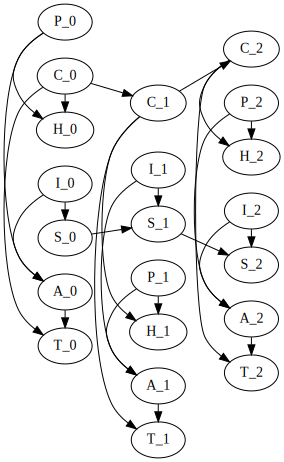

In [5]:
dag_view

### Looks good! Now we need to generate the data. 
* The following cell uses YAWNING TITAN to set up 10 different environments, each with a random value for $P$ and $I$, and runs them for 50 timesteps. 
* As said in the paper, features of the enironment are then used to calculate values for each of the nodes in our DAG
* The data is then in the `slice_data` dict, with keys for each node in the DAG

In [6]:
def create_env(use_same_net=False):
    """
    Helper function to create an environment.

    Args:
        use_same_net: If true uses a saved network, otherwise creates a new network

    Returns: The env

    """
    settings_path = "dcbo_config.yaml"

    if use_same_net:
        matrix, node_positions = network_creator.load_network("dcbo_base_net.txt")
    else:
        matrix, node_positions = network_creator.create_mesh(size=10)

    network_interface = NetworkInterface(
        matrix, node_positions, settings_path=settings_path
    )

    red = RedInterface(network_interface)
    blue = BlueInterface(network_interface)

    number_of_actions = blue.get_number_of_actions()

    env = GenericNetworkEnv(
        red,
        blue,
        network_interface,
        number_of_actions,
        show_metrics_every=10,
        collect_additional_per_ts_data=True,
    )

    check_env(env, warn=True)

    env.reset()

    return env

# Creates all 10 envs
all_envs = [create_env() for i in range(10)]
agent = DCBOAgent(all_envs[0].action_space, [0.5, 0.5])

TIMESTEPS = 25
COSTS = {"restore_node": 1, "isolate": 1, "do_nothing": 0, "compromise": 10}

centralities = nx.degree_centrality(all_envs[0].network_interface.current_graph)
slice_data = {k: [] for k in "PICSHAT"}

for counter, current_env in enumerate(all_envs):
    # Init data
    slice_p, slice_i, slice_s, slice_h, slice_c, slice_a, slice_t = (list() for i in range(7))
    
    # Init probabilities
    current_env.reset()
    agent.reset()

    w1, w2 = (
        random.gauss(0.5, 0.167),
        random.gauss(0.5, 0.167),
    )
    agent.update_probabilities([w1, w2])

    for i in range(TIMESTEPS):
        done = False
        current_step = 0

        action = agent.predict("", "", "", current_env)
        env_observation, reward, done, notes = current_env.step(action)

        c_cost = (COSTS["compromise"] * sum(notes["end_state"].values())) ** 1.5
        action_cost = COSTS.get(notes["blue_action"], 0)
        surface = sum(
            map(
                lambda x: not x[0] and not x[1],
                zip(
                    notes["end_state"].values(),
                    current_env.network_interface.get_all_isolation().values(),
                ),
            )
        )
        # Append P, I and S
        slice_p.append(agent.probabilities[0])
        slice_i.append(agent.probabilities[1])
        slice_s.append(surface) 
        
        # Calculate and append H
        h = 0
        node_states = current_env.network_interface.get_all_node_compromised_states()
        node_iso = current_env.network_interface.get_all_isolation()
        comp_nodes = [k for k in node_states if node_states[k] == 1]
        isolated_nodes = [k for k in node_iso if node_iso[k]]
        for node in comp_nodes:
            conn_nodes = current_env.network_interface.get_current_connected_nodes(node)
            for c in conn_nodes:
                if c in isolated_nodes:
                    continue
                h += current_env.network_interface.get_single_node_vulnerability(c)
        slice_h.append(h)
        # Append C, A and T
        slice_c.append(c_cost)
        slice_a.append(action_cost)
        slice_t.append(action_cost + c_cost)

    slice_data["P"].append(np.asarray(slice_p))
    slice_data["I"].append(np.asarray(slice_i))
    slice_data["S"].append(np.asarray(slice_s))
    slice_data["H"].append(np.asarray(slice_h))
    slice_data["C"].append(np.asarray(slice_c))
    slice_data["A"].append(np.asarray(slice_a))
    slice_data["T"].append(np.asarray(slice_t))

for k in slice_data.keys():
    slice_data[k] = np.asarray(slice_data[k])

In [7]:
print(f"Variables: {slice_data.keys()}")
print(f"Each variable has shape: {slice_data['P'].shape}")

Variables: dict_keys(['P', 'I', 'C', 'S', 'H', 'A', 'T'])
Each variable has shape: (10, 25)


### Great, now let's use our full dataset to build our model
* Since we have access to all the data, we can model the functional relationships between variables
* We can then use these models to calculate the ground truch best value for each of our manipulative variables ($P$ and $I$) in the final 3 timesteps
* We define a helper function for fitting GPs, then use this to fit a GP to each of the within-timeslice functions in our DAG

In [8]:
def fit_gp(
    x,
    y,
    lengthscale=1.0,
    variance=1.0,
    noise_var=1.0,
    ard=False,
    n_restart=10,
    seed: int = 0,
):
    """
    Helper function to fit a GP
    """
    kernel = RBF(x.shape[1], ARD=ard, lengthscale=lengthscale, variance=variance)
    model = GPRegression(X=x, Y=y, kernel=kernel, noise_var=noise_var)
    model.optimize_restarts(n_restart, verbose=False, robust=True)
    return model


In [9]:
time_vector = np.tile(
    np.linspace(0, slice_data["P"].shape[1] - 1, slice_data["P"].shape[1]),
    10
)[:, np.newaxis]


In [10]:
# Fit our GPs for t=0 (so no inter-timeslice dependencies)
model_P = fit_gp(time_vector, np.hstack(slice_data["P"])[:, np.newaxis])
model_I = fit_gp(time_vector, np.hstack(slice_data["I"])[:, np.newaxis])
model_S = fit_gp(
    np.hstack(slice_data["I"])[:, np.newaxis], np.hstack(slice_data["S"])[:, np.newaxis]
)
model_C = fit_gp(time_vector, np.hstack(slice_data["C"])[:, np.newaxis])
model_H = fit_gp(
    np.hstack(
        (
            np.hstack(slice_data["P"])[:, np.newaxis],
            np.hstack(slice_data["C"])[:, np.newaxis],
        )
    ), 
    np.hstack(slice_data["H"])[:, np.newaxis],
)
model_A = fit_gp(
    np.hstack(
        (
            np.hstack(slice_data["P"])[:, np.newaxis],
            np.hstack(slice_data["I"])[:, np.newaxis],
        )
    ),
    np.hstack(slice_data["A"])[:, np.newaxis],
)
model_T = fit_gp(
    np.hstack(
        (
            np.hstack(slice_data["C"])[:, np.newaxis],
            np.hstack(slice_data["A"])[:, np.newaxis],
        )
    ),
    np.hstack(slice_data["T"])[:, np.newaxis],
)


 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1


In [11]:
functions_0 = {
    "P": model_P,
    "I": model_I,
    "S": model_S,
    "H": model_H,
    "C": model_C,
    "A": model_A,
    "T": model_T,
}

#### Let's visualise our GPs to check they look sensible:

 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/likelihoods/gaussian.py:119: RuntimeWarning:invalid value encountered in sqrt


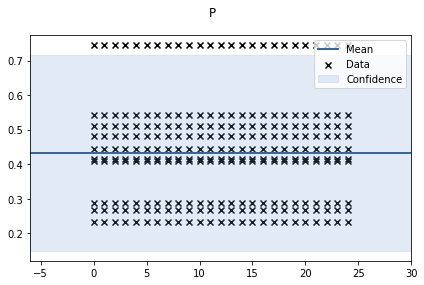

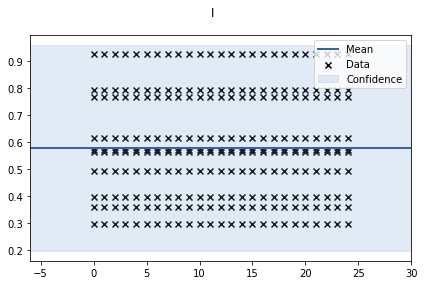

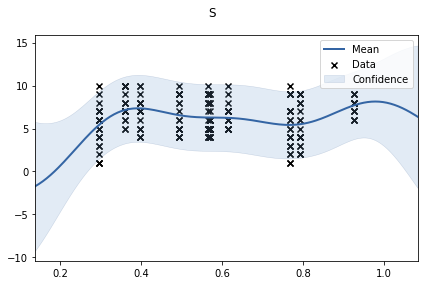

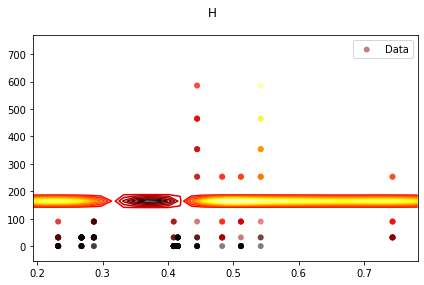

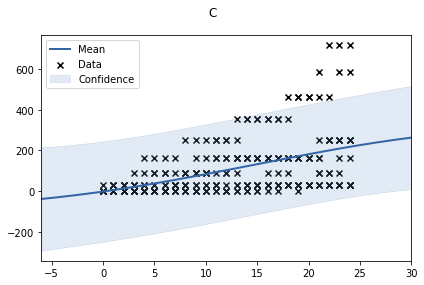

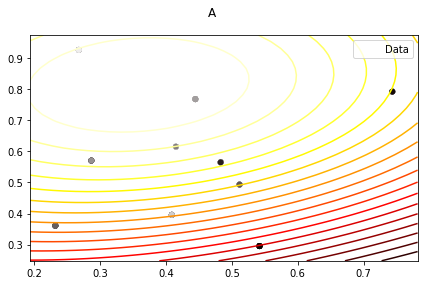

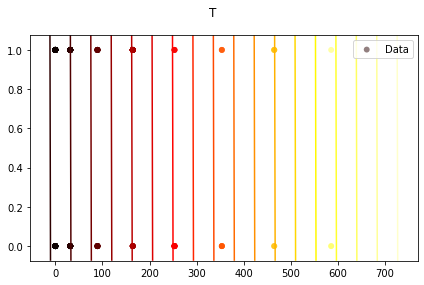

In [12]:
for k, m in functions_0.items():
    m.plot()
    plt.suptitle(k)


#### And let's also plot some of the variables from one of our environments, to see how it looks:

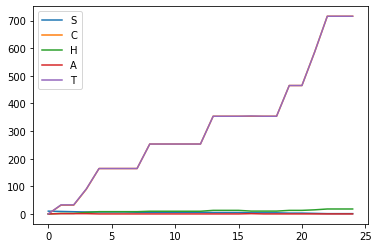

In [13]:
for var in "SCHAT":
    plt.plot(np.linspace(0, 24, 25), slice_data[var][1], label=var)
plt.legend()


### Okay, now we need to model the functions for $t > 0$, again using GPs.
* First, we rearrange the data so that it's easy to fit with our helper
  * Note that when we construct our arrays (e.g. `S_AR` in the below cell), we are constructing them so they map to the relationships in the DAG (e.g. `S_AR` contains data from $C_{t-1}$ and $I_{t}$, where $t$ is the current timeslice)
* Then, we fit

In [14]:
# Getting slice_data in the right form, based on the DAG
S_AR, H_AR, C_AR, A_AR, T_AR = [], [], [], [], []

for i in range(slice_data["P"].shape[0]):
    S_AR.append(
        np.transpose(np.vstack((slice_data["C"][i][:-1],slice_data["I"][i][1:],slice_data["S"][i][1:])))
    )
    C_AR.append(
        np.transpose(np.vstack((slice_data["H"][i][:-1],slice_data["C"][i][1:])))
    )
    H_AR.append(
        np.transpose(np.vstack((slice_data["P"][i][1:],slice_data["C"][i][1:],slice_data["H"][i][1:])))
    )
    A_AR.append(
        np.transpose(np.vstack((slice_data["P"][i][1:],slice_data["I"][i][1:],slice_data["A"][i][1:])))
    )
    T_AR.append(
        np.transpose(np.vstack((slice_data["C"][i][1:],slice_data["A"][i][1:],slice_data["T"][i][1:])))
    )

S_AR = np.vstack(S_AR)
H_AR = np.vstack(H_AR)
C_AR = np.vstack(C_AR)
A_AR = np.vstack(A_AR)
T_AR = np.vstack(T_AR)


In [15]:
model_S_t = fit_gp(S_AR[:, :-1], S_AR[:, -1][:, np.newaxis])
model_H_t = fit_gp(H_AR[:, :-1], H_AR[:, -1][:, np.newaxis])
model_C_t = fit_gp(C_AR[:, :-1], C_AR[:, -1][:, np.newaxis])
model_A_t = fit_gp(A_AR[:, :-1], A_AR[:, -1][:, np.newaxis])
model_T_t = fit_gp(T_AR[:, :-1], T_AR[:, -1][:, np.newaxis])


 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1


In [ ]:
functions_t = {
    "P": model_P,
    "I": model_I,
    "S": model_S_t,
    "H": model_H_t,
    "C": model_C_t,
    "A": model_A_t,
    "T": model_T_t,
}


#### Again, let's plot some of these functions to check they look sensible

 /tmp/ipykernel_16347/248468357.py:10: MatplotlibDeprecationWarning:Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


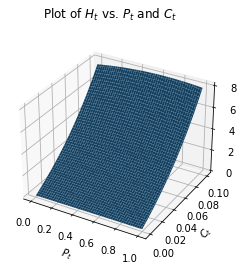

In [ ]:
C, P = np.meshgrid(
    np.linspace(-0.0, 0.1, 100)[:, np.newaxis],
    np.linspace(-0.0, 1.0, 100)[:, np.newaxis],
)
H_vals = model_H_t.predict(
    np.transpose(np.vstack((np.hstack(P), np.hstack(C))))
)[0]

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot_surface(P, C, H_vals.reshape(100, 100))
plt.xlabel("$P_t$")
plt.ylabel("$C_t$")
plt.suptitle("Plot of $H_t$ vs. $P_t$ and $C_{t}}$")
plt.show()


 /tmp/ipykernel_16347/3295890710.py:8: MatplotlibDeprecationWarning:Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


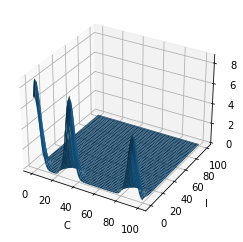

In [ ]:
I, C = np.meshgrid(
    np.linspace(-1.0, 100, 100)[:, np.newaxis],
    np.linspace(-1.0, 100, 100)[:, np.newaxis],
)
S_vals = model_S_t.predict(np.transpose(np.vstack((np.hstack(C), np.hstack(I)))))[0]

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot_surface(C, I, S_vals.reshape(100, 100))
plt.xlabel("C")
plt.ylabel("I")
plt.show()


### Great, so now we have models for all of the functions within our DAG, we can use them to build up our Structural Equation Model
* The `static` method of our SEM uses our $t = 0$ models to define the relationships between variables in the DAG in a static setting (e.g. just looking at one time slice)
* The `dynamic` method of our SEM uses our $t > 0$ models to define the relationships between variables in the DAG in a dynamic setting (e.g. taking account of temporal relationships)

In [ ]:
class PICSHAT_SEM:
    def __init__(self, functions_0, functions_t):
        self.functions_0 = functions_0
        self.functions_t = functions_t

    def static(self):

        P = (
            lambda noise, time, sample: noise
            + self.functions_0["P"].predict(time * np.ones((1, 1)))[0]
        )

        I = (
            lambda noise, time, sample: noise
            + self.functions_0["I"].predict(time * np.ones((1, 1)))[0]
        )

        S = (
            lambda noise, time, sample: noise
            + self.functions_0["S"].predict(
                np.transpose(np.vstack((sample["I"][time] * np.ones((1, 1)))))
            )[0]
        )

        C = (
            lambda noise, time, sample: noise
            + self.functions_0["C"].predict(time * np.ones((1, 1)))[0]
        )

        H = (
            lambda noise, time, sample: noise
            + self.functions_0["H"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["C"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        A = (
            lambda noise, time, sample: noise
            + self.functions_0["A"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["I"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        T = (
            lambda noise, time, sample: np.abs(
                noise
                + self.functions_0["T"].predict(
                    np.transpose(
                        np.vstack(
                            (
                                sample["C"][time] * np.ones((1, 1)),
                                sample["A"][time] * np.ones((1, 1)),
                            )
                        )
                    )
                )[0]
            )
        )

        return OrderedDict(
            [("P", P), ("I", I), ("S", S), ("H", H), ("C", C), ("A", A), ("T", T)]
        )

    def dynamic(self):

        P = (
            lambda noise, time, sample: noise
            + self.functions_t["P"].predict(time * np.ones((1, 1)))[0]
        )

        I = (
            lambda noise, time, sample: noise
            + self.functions_t["I"].predict(time * np.ones((1, 1)))[0]
        )

        S = (
            lambda noise, time, sample: noise
            + self.functions_t["S"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["C"][time - 1] * np.ones((1, 1)),
                            sample["I"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        C = (
            lambda noise, time, sample: noise
            + self.functions_t["C"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["H"][time - 1] * np.ones((1,1)),
                        )
                    )
                )
            )[0]
        )

        H = (
            lambda noise, time, sample: noise
            + self.functions_t["H"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["C"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        A = (
            lambda noise, time, sample: noise
            + self.functions_t["A"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["I"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        T = lambda noise, time, sample: np.abs(
            noise
            + self.functions_t["T"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["C"][time] * np.ones((1, 1)),
                            sample["A"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        return OrderedDict(
            [("P", P), ("I", I), ("S", S), ("H", H), ("C", C), ("A", A), ("T", T)]
        )


### Here, we set up some parameters for the optimisation

In [ ]:
intervention_domain = {"P": [0.0, 1.0], "I": [0.0, 1.0]}
exploration_sets = list(powerset(["P", "I"]))
n_to_compute = 50
interventional_grids = get_interventional_grids(
    exploration_sets, intervention_domain, size_intervention_grid=n_to_compute
)


In [ ]:
SEM = PICSHAT_SEM(functions_0, functions_t)
initial_structural_equation_model = SEM.static()
structural_equation_model = SEM.dynamic()


#### In the following cell, we use our SEM to calculate the ground truth optimal value for our interventional variables, $P$ and $I$
* N.b. - this can take a while to run, as it is searching the whole intervention space for the optimal value

In [ ]:
(
    best_s_values,
    best_s_sequence,
    best_objective_values,
    y_stars_all,
    optimal_interventions,
    all_CE,
) = optimal_sequence_of_interventions(
    exploration_sets,
    interventional_grids,
    initial_structural_equation_model,
    structural_equation_model,
    dag,
    T=T,
    model_variables=list("PISHCAT"),
    target_variable="T",
    task="min",
)


#### So now we have our ground truth optimal interventions:

In [ ]:
print("Best intervention set:", best_s_sequence)
print("Best intervention values:", best_s_values)
print("Best objective values:", best_objective_values)


Best intervention set: [('P', 'I'), ('P', 'I'), ('P', 'I')]
Best intervention values: [array([0.71428571, 0.30612245]), array([0.55102041, 0.40816327]), array([0.55102041, 0.40816327])]
Best objective values: [10.456831027765979, 8.894052982330322, 8.894052982330322]


### Now we're going to actually run the experiment.
* We run each optimisation algorithm, giving each one 50 samples to converge on it's optimal objective value for each of the final 3 timesteps
* We run each algorithm 3 times, so we can plot uncertainty bounds and averge performance

In [ ]:
subset_obs_data = deepcopy(slice_data)
for var in subset_obs_data.keys():
    subset_obs_data[var] = subset_obs_data[var][:, -3:]


In [ ]:
# See method for argument details
R, N = 3, 50
results = run_methods_replicates(
    G=dag,
    sem=PICSHAT_SEM,
    make_sem_estimator=build_sem_hat,
    base_target_variable='T',
    intervention_domain = intervention_domain,
    methods_list = ['DCBO', 'CBO', 'BO'],
    obs_samples = subset_obs_data,
    exploration_sets = exploration_sets,
    total_timesteps = T,
    number_of_trials = N,
    reps = R, # Number of replicates (how many times we run each method)
    n_restart = 1,
    save_data = False,
    n_obs = 5, # The method samples 5 time-series for each replicate
    num_anchor_points = 100,
    sample_anchor_points = True,
    controlled_experiment=True,
    args_sem=[functions_0, functions_t],
    manipulative_variables=["P", "I"]
)

Experiment count:   0%|          | 0/3 [00:00<?, ?it/s]


	>>>DCBO



 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning


	>>>CBO



 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
 /home/sam/miniconda3/envs/bt/lib


	>>>BO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Experiment count:  33%|███▎      | 1/3 [12:34<25:09, 754.61s/it]


	>>>DCBO



 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [05:05<00:00, 101.71s/it]



	>>>CBO



 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regr


	>>>BO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Experiment count:  67%|██████▋   | 2/3 [24:37<12:16, 736.07s/it]


	>>>DCBO



 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [05:39<00:00, 113.07s/it]



	>>>CBO



 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/sam/miniconda3/envs/bt/lib/python3.9/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in expm1
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regr


	>>>BO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Experiment count: 100%|██████████| 3/3 [37:19<00:00, 746.64s/it]


### Now, we collect our data from the experiment, and plot it

In [ ]:
# Since we didn't save the results we cannot use the pickled file so we have to convert results to the correct format
data = get_relevant_results(results=results,replicates=R)
exp_optimal_outcome_values_during_trials, exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=data, 
                                                                         best_objective_values=best_objective_values, 
                                                                         T=T)

In [ ]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.2,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCBO': 'DCBO', 'CBO': 'CBO', 'ABO': 'ABO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCBO': 'blue', 'CBO': 'green', 'ABO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCBO': '-', 'CBO': '--', 'ABO': 'dashdot', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

In [ ]:
class PlainOffsetScalarFormatter(ScalarFormatter):
    def get_offset(self):
        if len(self.locs) == 0:
            return ''
        if self.orderOfMagnitude:
            pass
            # print("Your plot will likely be labelled incorrectly")
        return "$\\times 10^{-5}+$" + str(round(self.offset, 5))

In [ ]:
y_lim_list = {0: (10.3, 11.3), 1: (8.8, 10.5), 2: (8.88, 9.1)}

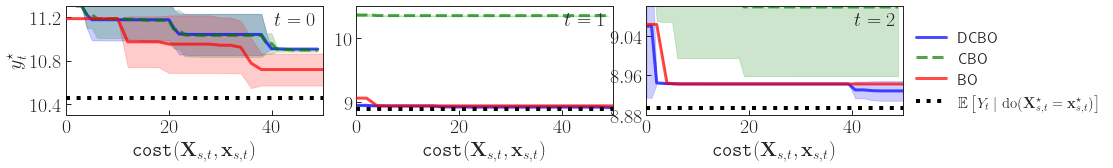

In [ ]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    best_objective_values,
    exp_per_trial_cost,
    exp_optimal_outcome_values_during_trials,
    plot_params, 
    fig_size = (15,2),
    # y_lim_list = y_lim_list,
    # filename="final_50_trials"
    )